In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from utils import make_confusion_matrix, atomic_benchmark_estimator

In [5]:
df = pd.read_csv("./data/Notebook 2 Data/data.csv")
df.dropna(axis=0, inplace=True)
df.drop(["id", "time", "period.name", "start.time", "score"], axis=1, inplace=True)
target = df['class']
X_train, X_valid, y_train, y_valid = train_test_split(
    df, target, test_size=0.2, stratify=target, random_state=99)

X_train = X_train.drop(['class'], axis=1)
X_valid = X_valid.drop(['class'], axis=1)
df.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,class
0,3.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0
1,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,1.0,2.0,0.0,0.0,2.0,3.0,0.0,3.0,2.0
4,1.0,3.0,1.0,1.0,2.0,1.0,2.0,3.0,0.0,1.0,3.0


In [14]:
process = tf.keras.layers.Normalization()
process.adapt(X_train)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)).batch(128).prefetch(tf.data.AUTOTUNE)

In [9]:
labels = [
    'True Normal', 'False Mild', 'False Moderate', 'False Severe', 'False Extremely Severe',
    'False Normal', 'True Mild', 'False Moderate', 'False Severe', 'False Extremely Severe',
    'False Normal', 'False Mild', 'True Moderate', 'False Severe', 'False Extremely Severe',
    'False Normal', 'False Mild', 'False Moderate', 'True Severe', 'False Extremely Severe',
    'False Normal', 'False Mild', 'False Moderate', 'False Severe', 'True Extremely Severe',
]
categories = ['0', '1', '2', '3', '4']
METRICS = ["acc"]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='acc', patience=10, restore_best_weights=True, mode="max")

In [15]:
input = tf.keras.layers.Input(shape=(10, ))
x = process(input)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
output = tf.keras.layers.Dense(5, activation="softmax")(x)

nn_1 = tf.keras.Model(input, output)

nn_1.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=METRICS
)
# nn_1.summary()
history_1 = nn_1.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/100
100/100 - 1s - loss: 1.4979 - acc: 0.3210 - val_loss: 1.3235 - val_acc: 0.5105 - 685ms/epoch - 7ms/step
Epoch 2/100
100/100 - 0s - loss: 1.2225 - acc: 0.6014 - val_loss: 1.1239 - val_acc: 0.6383 - 324ms/epoch - 3ms/step
Epoch 3/100
100/100 - 0s - loss: 1.0398 - acc: 0.6844 - val_loss: 0.9554 - val_acc: 0.7246 - 388ms/epoch - 4ms/step
Epoch 4/100
100/100 - 0s - loss: 0.8794 - acc: 0.7485 - val_loss: 0.7983 - val_acc: 0.7601 - 378ms/epoch - 4ms/step
Epoch 5/100
100/100 - 0s - loss: 0.7210 - acc: 0.7829 - val_loss: 0.6361 - val_acc: 0.8016 - 346ms/epoch - 3ms/step
Epoch 6/100
100/100 - 0s - loss: 0.5701 - acc: 0.8238 - val_loss: 0.5005 - val_acc: 0.8386 - 326ms/epoch - 3ms/step
Epoch 7/100
100/100 - 0s - loss: 0.4503 - acc: 0.8683 - val_loss: 0.3964 - val_acc: 0.8826 - 330ms/epoch - 3ms/step
Epoch 8/100
100/100 - 0s - loss: 0.3626 - acc: 0.8903 - val_loss: 0.3254 - val_acc: 0.8989 - 337ms/epoch - 3ms/step
Epoch 9/100
100/100 - 0s - loss: 0.3041 - acc: 0.9034 - val_loss: 0.2777

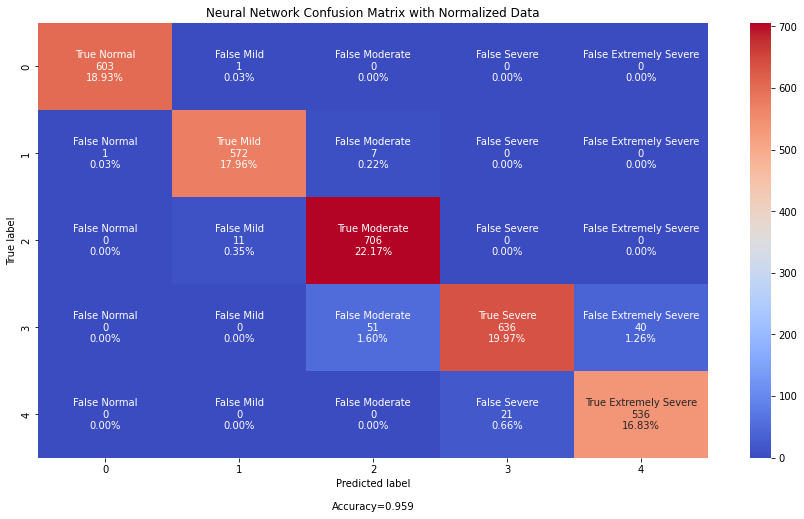

In [16]:
y_pred = nn_1.predict(X_valid).squeeze()
y_pred = tf.argmax(tf.where(y_pred > 0.5, 1, 0), axis=1)
y_pred = y_pred.numpy()

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(nn_1, pd.DataFrame(X_valid))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Neural Network Confusion Matrix with Normalized Data"
)

In [17]:
nn_1.save("model.h5")

In [19]:
!tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model model.h5 model/

Writing weight file model/model.json...


2022-06-09 17:20:19.372074: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 17:20:19.948025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2043 MB memory:  -> device: 0, name: GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-06-09 17:20:20.801786: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-09 17:20:21.258120: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-06-09 17:20:21.259048: I tensorflow/core/grappler/cluste